# Fundamentos
Los Datasets y DataLoaders son funciones de pytorch que nos permites cargas, preprocesar y gestionar sets de datos de manera eficiente en pytorch. Con esto nos aseguramos de procesar nuestro dataset fuera del loop de entrenamiento en pytorch

### Datasets
Clase la cual crea un objeto que contiene nuestro set de datos, debe contar con las siguientes funciones:
- \_\_init\_\_ : inicializador del objeto
- \_\_len\_\_ : Función que regresa la longitud del set de datos
- \_\_getitem\_\_ : Regresa un elemento del set de datos en forma de tupla, regesa el registro y si etiqueta

### DataLoaders
Clase la cual crea un objeto que arma los batches de datos y los organiza para entrenamiento y evaluación

In [17]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Data tabular
Un ejemplo de dataset y dataloaders con datos de un csv

In [18]:
archivo = os.path.join('.','./data/churn.csv')

In [19]:
class Dataset_Custom(Dataset):
    def __init__(self, data_dir):
        data = pd.read_csv(data_dir)
        self.x, self.y = self.limpieza(data)
        self.samples = self.y.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx] # Se regresa un registro de datos junto con su etiqueta

    def __len__(self):
        return self.samples

    def limpieza(self,data):
        datos_y = data[data.columns[-1]]
        datos_x = data.drop(columns=["RowNumber", "CustomerId", "Surname", "Exited"])
        datos_x = pd.get_dummies(datos_x)
        escalador = StandardScaler()
        datos_x = escalador.fit_transform(datos_x)
        x = torch.from_numpy(datos_x).float()
        y = torch.from_numpy(datos_y.values).float()
        y = y[:,None]
        return x,y



In [20]:
# Generamos un objeto de la clase Dataset_Custom
set_datos = Dataset_Custom(archivo)

In [22]:
# Podemos leer datos de nuestro set de datos con las funciones de la  clase 'Dataset_Custom'
set_datos.__getitem__(43) #Se puede buscar por idx
# set_datos[0]

(tensor([ 1.8983,  0.9610, -1.0418,  0.8800, -0.9116, -1.5478, -1.0307,  1.6394,
          0.9972, -0.5787, -0.5738,  1.0960, -1.0960]),
 tensor([1.]))

In [23]:
# Creamos un data loader dandole el set de datos, el tamaño de batch, el numero de procesos en paralelo, tomar muestras aleatorias etc. 
dataloader = DataLoader(dataset=set_datos, batch_size=2, shuffle=False) # Se puede poner num_workers para definir los hilos

In [24]:
# El dataloader puede ser iterado como una lista ej. for i in dataloader:
iterador = iter(dataloader)

In [26]:
iterador.next()

[tensor([[-1.5368,  0.2935,  1.0329,  1.3331,  2.5271,  0.6461, -1.0307,  0.2407,
           0.9972, -0.5787, -0.5738,  1.0960, -1.0960],
         [ 0.5015,  0.0075, -1.3875, -1.2258,  0.8077, -1.5478, -1.0307, -0.1089,
           0.9972, -0.5787, -0.5738,  1.0960, -1.0960]]),
 tensor([[1.],
         [0.]])]

In [28]:
# Asi se puede iterar sobre cada elemento del dataset
# Un ciclo asi se puede usar dentro del loop de entrenamiento 
for i in enumerate(dataloader):
    print(i)

(0, [tensor([[-0.3262,  0.2935, -1.0418, -1.2258, -0.9116,  0.6461,  0.9702,  0.0219,
          0.9972, -0.5787, -0.5738,  1.0960, -1.0960],
        [-0.4400,  0.1982, -1.3875,  0.1174, -0.9116, -1.5478,  0.9702,  0.2165,
         -1.0028, -0.5787,  1.7427,  1.0960, -1.0960]]), tensor([[1.],
        [0.]])])
(1, [tensor([[-1.5368,  0.2935,  1.0329,  1.3331,  2.5271,  0.6461, -1.0307,  0.2407,
          0.9972, -0.5787, -0.5738,  1.0960, -1.0960],
        [ 0.5015,  0.0075, -1.3875, -1.2258,  0.8077, -1.5478, -1.0307, -0.1089,
          0.9972, -0.5787, -0.5738,  1.0960, -1.0960]]), tensor([[1.],
        [0.]])])
(2, [tensor([[ 2.0639,  0.3889, -1.0418,  0.7857, -0.9116,  0.6461,  0.9702, -0.3653,
         -1.0028, -0.5787,  1.7427,  1.0960, -1.0960],
        [-0.0572,  0.4842,  1.0329,  0.5973,  0.8077,  0.6461, -1.0307,  0.8637,
         -1.0028, -0.5787,  1.7427, -0.9124,  0.9124]]), tensor([[0.],
        [1.]])])
(3, [tensor([[ 1.7742,  1.0563,  0.6871, -1.2258,  0.8077,  0.6461,  0

# Dataset con imagenes
Ejemplos de dataset, dataloader y transformaciones sobre set de datos de imagenes
Se cuenta con la siguiente estructura de archivos:
```python
data/
├─ etiquetas/
│  ├─ train.csv # Archivo con file_name,file_path,class_name,class_index
├─ imagenes/
│  ├─ seg_train/ # Carpeta con imagenes a procesar
│  │  ├─ imagenes_entrenamiento

```


In [29]:
import cv2
import random
from torchvision import transforms
import PIL

## Dataset 'básico'

In [30]:
class Dataset_Imagenes(torch.utils.data.Dataset): 
    '''
    Clase que inicializa el dataset, tiene una funcion para obtener el tamaño del mismo y una función para extraer ejemplos del set de datos 
    '''
    def __init__(self, archivo_etiquetas, img_dir="", transform=None):
        self.etiquetas_df = pd.read_csv(archivo_etiquetas) 
        self.img_dir = img_dir # Directorio donde estan las imagenes
        self.transform = transform # Las transformaciones que se le tienen que hacer a la imagen

    def __len__(self):
        return len(self.etiquetas_df) 

    def __getitem__(self, idx):
        directorio_imagen = os.path.join(self.img_dir, self.etiquetas_df.iloc[idx, 1]) 
        imagen = cv2.imread(directorio_imagen) 
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        clase = self.etiquetas_df.iloc[idx, 2] 
        if self.transform:
            imagen = self.transform(imagen)
        return imagen, clase

In [31]:
# Creamos dataset
set_datos_imagenes = Dataset_Imagenes(archivo_etiquetas='./data/etiquetas/train.csv',
                                                img_dir="", transform=None)
#Creamos dataloader
dataloader_imagenes= DataLoader(set_datos_imagenes, 1, shuffle=True)

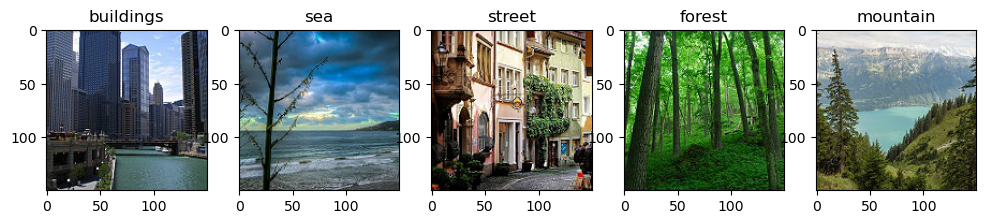

In [32]:
plt.figure(figsize=(12,6))
#Accedemos a 5 registros del dataloader
for i in enumerate(dataloader_imagenes): 
    imagen = i[1][0][0]
    clase = i[1][1][0]
    ax=plt.subplot(2,5,i[0]+1) 
    ax.title.set_text(clase) 
    plt.imshow(imagen)
    if i[0]==4:
        break

In [39]:
# Creamos una funcion con distintas transformaciones
transformacion = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    transforms.GaussianBlur(13,2),
    transforms.Resize((100, 100),
    interpolation=PIL.Image.BILINEAR)])

/Users/alex/miniforge3/envs/clasif/lib/python3.8/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [40]:
# Creamos dataset
set_datos_imagenes_t = Dataset_Imagenes(archivo_etiquetas='./data/etiquetas/train.csv', 
                                img_dir="",
                                transform=transformacion)

#Creamos dataloader                                
dataloader_imagenes_transformadas= DataLoader(set_datos_imagenes_t, 1, shuffle=True)

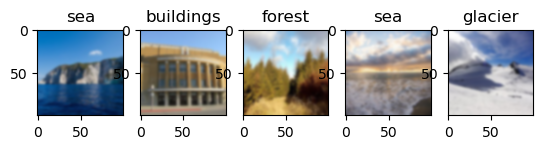

In [41]:
for i in enumerate(dataloader_imagenes_transformadas): 
    image = i[1][0][0]
    clase = i[1][1][0]
    ax=plt.subplot(2,5,i[0]+1) 
    ax.title.set_text(clase) 
    plt.imshow(image.permute(1,2,0))
    if i[0]==4:
        break